### Display graph with winnings for given year(s)

#### For reaching classes outside folder

In [14]:
import sys
sys.path.append('../../')

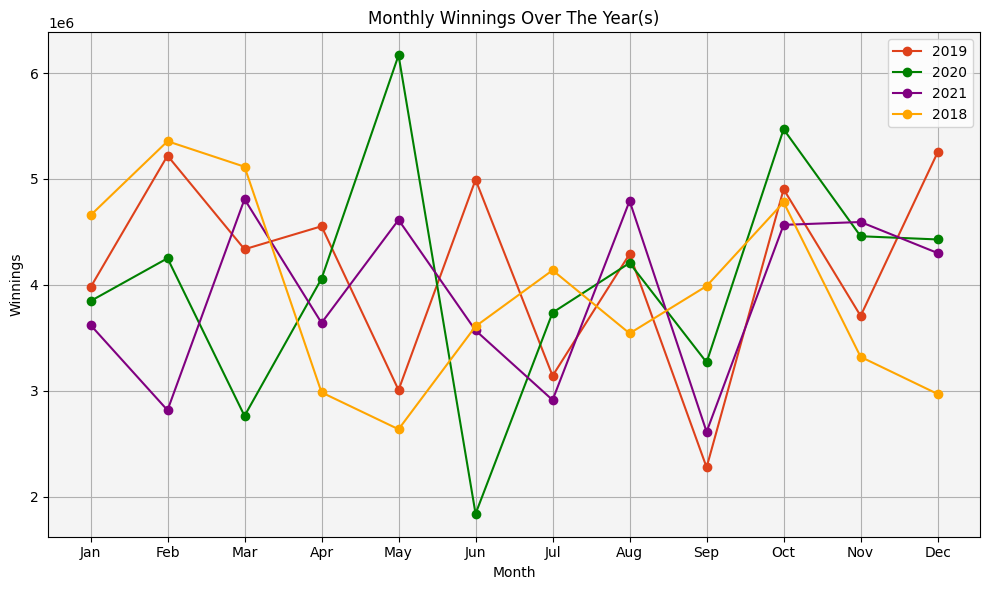

In [16]:
import importlib
import sys
from data.DbUtils import DbUtils
import matplotlib.pyplot as plt
from datetime import datetime
importlib.reload(sys.modules['DbUtils'])


def print_winnings_graph_for_years(years):
    dbUtils = DbUtils()
    current_date = datetime.now().date()

    plt.figure(figsize=(10, 6))
    line_colors = ['#de411b', 'green', 'purple', 'orange', 'blue']

    for i, year in enumerate(years):
        monthly_winnings_list = []
        max_month = 12
        if year == current_date.year:
            max_month = current_date.month

        for month in range(1, max_month + 1):
            events = dbUtils.get_events_by_year_month(year, month)
            monthly_winnings = 0
            for event in events:
                final_winnings = dbUtils.get_final_winnings_for_event(event)
                monthly_winnings += final_winnings
            monthly_winnings_list.append(monthly_winnings)

        plt.plot(
            range(1, max_month + 1),
            monthly_winnings_list,
            marker='o',
            color=line_colors[i % len(line_colors)],
            label=str(year)
        )
        plt.xlabel('Month')
        plt.ylabel('Winnings')
        plt.title('Monthly Winnings Over The Year(s)')
        plt.legend()
        plt.grid(True)  # Adding grid lines

        # Adding x-axis labels for each month
        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        plt.xticks(range(1, max_month + 1), month_labels[:max_month])

        ax = plt.gca()
        ax.set_facecolor('#f4f4f4')

    plt.tight_layout()
    plt.show()
years = [
    2019, 2020, 2021, 2018
]
print_winnings_graph_for_years(years)


### Data preparation
Year - Month - Sales

In [2]:
from datetime import datetime

parsing_years = [2018, 2019, 2020, 2021, 2022, 2023]
current_date = datetime.now().date()

years = []
months = []
sales = []
dbUtils = DbUtils()
max_month = 13
for year in parsing_years:
    if year == current_date.year:
        max_month = current_date.month

    for month in range(1, max_month):
        events = dbUtils.get_events_by_year_month(year, month)
        monthly_winnings = 0
        for event in events:
            winnings = dbUtils.get_final_winnings_for_event(event)
            monthly_winnings += winnings
        years.append(year)
        months.append(month)
        sales.append(monthly_winnings)

In [3]:
import numpy as np
years = np.array(years)
months = np.array(months)
sales = [float(sale) for sale in sales]
sales = np.array(sales)

In [5]:
input_features = [(year, month) for year, month in zip(years, months)]
target_sales = sales

### Data splitting

In [6]:
import random

data = list(zip(input_features, target_sales))
random.shuffle(data)

split_index = int(0.7 * len(data))  # 70% for training, 30% for validation

# Split the data into training and validation sets
train_data = data[:split_index]
validation_data = data[split_index:]

# Separate input features and target sales for training and validation
train_input_features, train_target_sales = zip(*train_data)
validation_input_features, validation_target_sales = zip(*validation_data)

In [18]:
window_size = 12
train_sequences = []
validation_sequences = []

for i in range(len(train_input_features) - window_size + 1):
    if i + window_size <= len(train_input_features):
        train_sequence = train_input_features[i : i + window_size]
        train_sequences.append(train_sequence)

for i in range(len(validation_input_features) - window_size + 1):
    if i + window_size <= len(validation_input_features):
        validation_sequence = validation_input_features[i : i + window_size]
        validation_sequences.append(validation_sequence)

train_sequences = np.array(train_sequences)
validation_sequences = np.array(validation_sequences)


# Print sequences
print(train_sequences[:3])
print(validation_sequences[:3])

[[[2022    3]
  [2020    7]
  [2021   11]
  [2020   11]
  [2022    2]
  [2021    2]
  [2022    6]
  [2023    3]
  [2022    7]
  [2020   10]
  [2019    6]
  [2020    2]]

 [[2020    7]
  [2021   11]
  [2020   11]
  [2022    2]
  [2021    2]
  [2022    6]
  [2023    3]
  [2022    7]
  [2020   10]
  [2019    6]
  [2020    2]
  [2019    3]]

 [[2021   11]
  [2020   11]
  [2022    2]
  [2021    2]
  [2022    6]
  [2023    3]
  [2022    7]
  [2020   10]
  [2019    6]
  [2020    2]
  [2019    3]
  [2018    2]]]
[[[2019   10]
  [2021    6]
  [2023    6]
  [2021    8]
  [2021    5]
  [2023    4]
  [2018    4]
  [2018    5]
  [2019    8]
  [2021    4]
  [2022   10]
  [2019    7]]

 [[2021    6]
  [2023    6]
  [2021    8]
  [2021    5]
  [2023    4]
  [2018    4]
  [2018    5]
  [2019    8]
  [2021    4]
  [2022   10]
  [2019    7]
  [2018   12]]

 [[2023    6]
  [2021    8]
  [2021    5]
  [2023    4]
  [2018    4]
  [2018    5]
  [2019    8]
  [2021    4]
  [2022   10]
  [2019    7]
  [2018   

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(
                        window_size, # window_size, how far the LSTM will look back  
                        2,  # num_features
                    )   
                )
        )
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mse')


In [20]:
train_target_sales = np.array(train_target_sales)
validation_target_sales = np.array(validation_target_sales)
train_target_sales = train_target_sales[:len(train_sequences)]
validation_target_sales = validation_target_sales[:len(validation_sequences)]
model.fit(train_sequences, 
          train_target_sales, 
          epochs=1000, 
          batch_size=10, 
          validation_data=(validation_sequences, validation_target_sales)
        )

Epoch 1/1000
4/4 [==============================] - 1s 73ms/step - loss: 17741620707328.0000 - val_loss: 16236022857728.0000
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 17741417283584.0000 - val_loss: 16233434972160.0000
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 17740305793024.0000 - val_loss: 16233018687488.0000
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 17739596955648.0000 - val_loss: 16231005421568.0000
Epoch 5/1000
4/4 [==============================] - 0s 13ms/step - loss: 17737097150464.0000 - val_loss: 16229283659776.0000
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 17735943716864.0000 - val_loss: 16228327358464.0000
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 17736788869120.0000 - val_loss: 16231853719552.0000
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 17738380607488.0000 - val_loss: 16230919438336.0000


In [34]:
model.save("model_predict_sales_for_year_month.h5")

In [17]:
from keras.models import load_model

model2 = load_model("model_predict_sales_for_year_month.h5")

In [18]:
from models.SalesModel import SalesModel
importlib.reload(sys.modules['SalesModel'])
my_model = SalesModel()

In [20]:
prediction = my_model.predict_sale_for_year_month(2022, 8)
print(prediction)

1/1 [==============================] - 0s 30ms/step
4267455.5


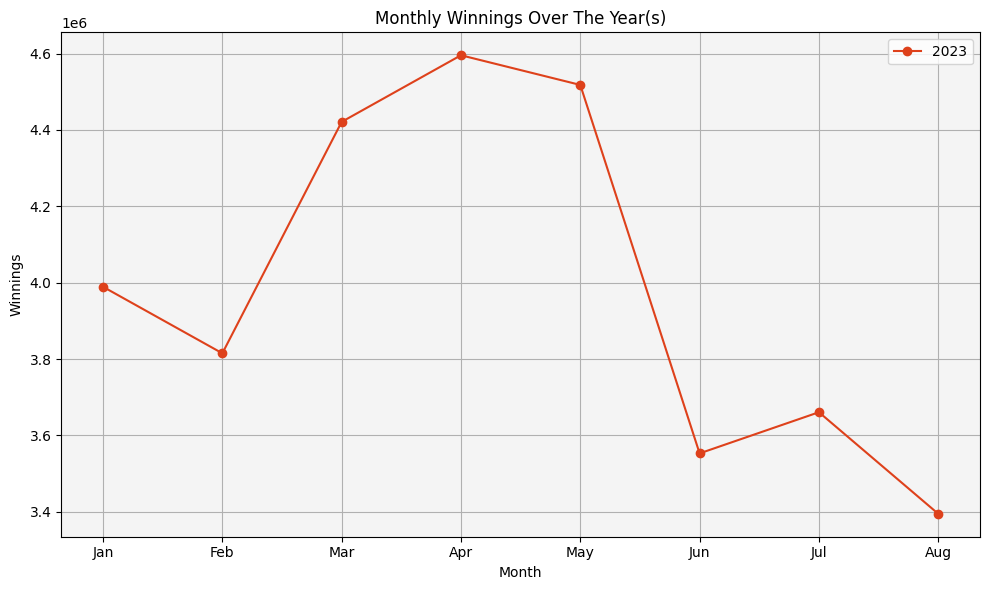

In [12]:
from plotting.GraphPlotter import GraphPlotter
import importlib
import sys
importlib.reload(sys.modules['GraphPlotter'])

plotter = GraphPlotter()
plotter.print_winnings_graph_for_years([2023])